# OneClassSVM

In [99]:
!pip install --upgrade scikit-learn

In [100]:
import pandas as pd
import os
from matplotlib import pyplot as plt
import datetime as dt
import numpy as np

from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [101]:
# Mounting the drive to access the datasets
from google.colab import drive
drive.mount('/content/drive')

os.chdir("/content/drive/My Drive/Colab Notebooks")
os.getcwd()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/My Drive/Colab Notebooks'

## Heart Disease Dataset

In [102]:
# The dataset is loaded into google drive and then read
df = pd.read_csv('cardio_train.csv', delimiter=';')

In [103]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62,110,80,1,1,0,0,1,0
1,1,20228,1,156,85,140,90,3,1,0,0,1,1
2,2,18857,1,165,64,130,70,3,1,0,0,0,1
3,3,17623,2,169,82,150,100,1,1,0,0,1,1
4,4,17474,1,156,56,100,60,1,1,0,0,0,0


In [104]:
df.shape

(70000, 13)

In [105]:
df.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000,70000,70000,70000,70000,70000,70000,70000,70000,70000,70000,70000,70000
mean,49972,19469,1,164,74,129,97,1,1,0,0,1,0
std,28851,2467,0,8,14,154,188,1,1,0,0,0,1
min,0,10798,1,55,10,-150,-70,1,1,0,0,0,0
25%,25007,17664,1,159,65,120,80,1,1,0,0,1,0
50%,50002,19703,1,165,72,120,80,1,1,0,0,1,0
75%,74889,21327,2,170,82,140,90,2,1,0,0,1,1
max,99999,23713,2,250,200,16020,11000,3,3,1,1,1,1


In [106]:
df['cardio'].value_counts()

0    35021
1    34979
Name: cardio, dtype: int64

<Axes: >

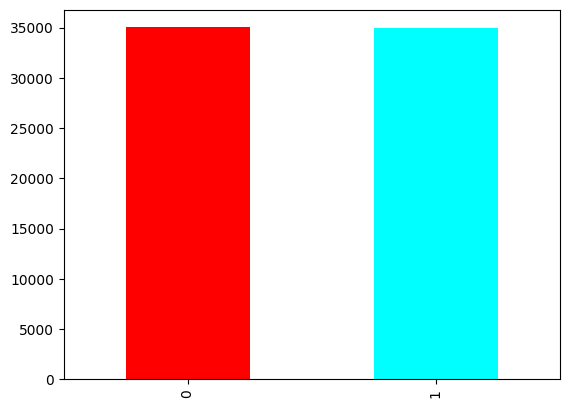

In [107]:
df['cardio'].value_counts().plot(kind='bar', color=['Red', 'Cyan'])

In [108]:
df.isna().sum()

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

### Basic Preprocessing

In [109]:
# Converting the age in days to years
df['age'] = df['age']/365
df['age'] = df['age'].round(2)

In [110]:
# Converting the height in cm to ft
df['height'] = df['height']*0.032808399
df['height'] = df['height'].round(2)

In [111]:
df = df.rename(columns={'age': 'age_years', 'height': 'height_ft'})

df = df.drop("id", axis=1)

In [112]:
df.head()

,age_years,gender,height_ft,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50,2,6,62,110,80,1,1,0,0,1,0
1,55,1,5,85,140,90,3,1,0,0,1,1
2,52,1,5,64,130,70,3,1,0,0,0,1
3,48,2,6,82,150,100,1,1,0,0,1,1
4,48,1,5,56,100,60,1,1,0,0,0,0


In [113]:
df['cardio'].value_counts(normalize=True)

0   1
1   0
Name: cardio, dtype: float64

In [114]:
train_data, test_data = train_test_split(df, test_size=0.3, random_state=42)

In [115]:
# Separate instances belonging to class 0 and class 1 in the train dataset
class_0_instances_train = train_data[train_data['cardio'] == 0]
class_1_instances_train = train_data[train_data['cardio'] == 1]

# Calculate the number of instances needed for 5% of class 1 in the train dataset
num_class_1_instances_train = int(0.05 * len(class_1_instances_train))

# Sample 5% of class 1 instances randomly from the train dataset
class_1_sample_train = class_1_instances_train.sample(n=num_class_1_instances_train, random_state=42)

# Combine the sampled class 1 instances with all class 0 instances in the train dataset
train_data = pd.concat([class_0_instances_train, class_1_sample_train])

# Shuffle the train dataset to ensure randomness
train_data = train_data.sample(frac=1, random_state=42)

In [116]:
train_data['cardio'].value_counts(normalize=True)

0   1
1   0
Name: cardio, dtype: float64

In [117]:
train_data = train_data.reset_index(drop=True)

X_train_data = train_data.drop("cardio", axis=True)

y_train_data = train_data["cardio"]

In [118]:
X_train_data.head()

,age_years,gender,height_ft,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,44,1,5,65,120,80,1,1,0,0,1
1,60,1,6,72,110,79,1,1,0,0,1
2,53,2,6,86,140,90,1,1,0,0,1
3,60,1,5,67,110,80,1,1,0,0,1
4,50,1,5,56,120,80,2,2,0,0,1


In [119]:
one_class_svm = OneClassSVM(nu=0.05, kernel='rbf', gamma='auto').fit(X_train_data)

In [120]:
# Separate instances belonging to class 0 and class 1 in the test dataset
class_0_instances_test = test_data[test_data['cardio'] == 0]
class_1_instances_test = test_data[test_data['cardio'] == 1]

# Calculate the number of instances needed for 5% of class 1 in the test dataset
num_class_1_instances_test = int(0.05 * len(class_1_instances_test))

# Sample 5% of class 1 instances randomly from the test dataset
class_1_sample_test = class_1_instances_test.sample(n=num_class_1_instances_test, random_state=42)

# Combine the sampled class 1 instances with all class 0 instances in the test dataset
test_data = pd.concat([class_0_instances_test, class_1_sample_test])

# Shuffle the test dataset to ensure randomness
test_data = test_data.sample(frac=1, random_state=42)

In [121]:
test_data = test_data.reset_index(drop=True)

X_test_data = test_data.drop("cardio", axis=True)

y_test_data = test_data["cardio"]

In [122]:
X_test_data.head()

,age_years,gender,height_ft,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,48,1,6,76,120,80,1,1,0,0,1
1,53,1,5,88,120,80,1,1,1,0,1
2,60,1,5,65,140,90,1,1,0,0,1
3,52,1,5,61,120,80,1,1,0,0,1
4,64,2,5,57,110,80,1,1,0,0,1


In [123]:
# Predict the anomalies
prediction = one_class_svm.predict(X_test_data)

In [124]:
# Change the anomalies' values to make it consistent with the true values
prediction = [1 if i==-1 else 0 for i in prediction]
# Check the model performance
print(classification_report(y_test_data, prediction))

              precision    recall  f1-score   support

           0       0.96      0.73      0.83     10461
           1       0.08      0.44      0.13       526

    accuracy                           0.72     10987
   macro avg       0.52      0.59      0.48     10987
weighted avg       0.92      0.72      0.80     10987



In [125]:
test_data['cardio'].value_counts()

0    10461
1      526
Name: cardio, dtype: int64

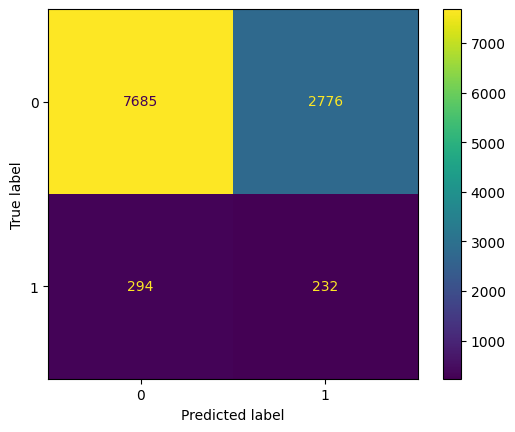

In [126]:
cm = confusion_matrix(y_test_data, prediction)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

## Credit Card Dataset

In [127]:
# Dataset is read from google drive
df_cc = pd.read_csv('fraudTrain.csv')

df_cc.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,5,Jennifer,Banks,F,561 Perry Cove,...,36,-81,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36,-82,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,49,-118,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49,-118,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220,Edward,Sanchez,M,594 White Dale Suite 530,...,42,-112,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43,-112,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46,-112,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47,-113,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,42,Tyler,Garcia,M,408 Bradley Rest,...,38,-79,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,39,-79,0


In [128]:
df_cc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

In [129]:
pd.set_option('display.float_format', lambda x: f'{x:.0f}')

df_cc.describe()

,Unnamed: 0,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1296675,1296675,1296675,1296675,1296675,1296675,1296675,1296675,1296675,1296675,1296675
mean,648337,417192042079726656,70,48801,39,-90,88824,1349243637,39,-90,0
std,374318,1308806447000240384,160,26893,5,14,301956,12841278,5,14,0
min,0,60416207185,1,1257,20,-166,23,1325376018,19,-167,0
25%,324168,180042946491150,10,26237,35,-97,743,1338750742,35,-97,0
50%,648337,3521417320836166,48,48174,39,-87,2456,1349249747,39,-87,0
75%,972506,4642255475285942,83,72042,42,-80,20328,1359385376,42,-80,0
max,1296674,4992346398065154048,28949,99783,67,-68,2906700,1371816817,68,-67,1


In [130]:
df_cc.isna().sum()

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

In [131]:
df_cc.drop_duplicates(inplace=True)

df_cc.shape

(1296675, 23)

<Axes: >

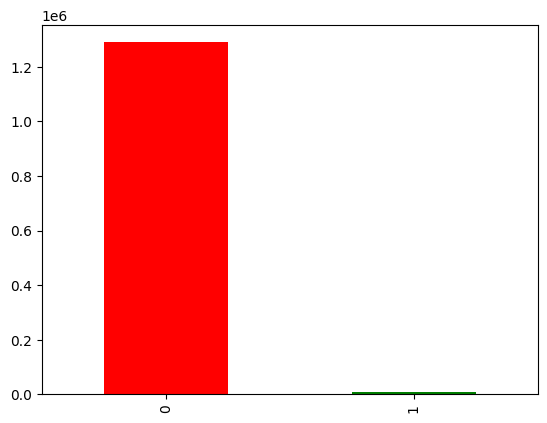

In [132]:
df_cc['is_fraud'].value_counts().plot(kind='bar', color=['Red', 'Green'])

In [133]:
# Finding the unique values in each feature
for column in df_cc.columns:
    unique_values = df_cc[column].nunique()
    print("Unique values in", column, ":", unique_values)

Unique values in Unnamed: 0 : 1296675
Unique values in trans_date_trans_time : 1274791
Unique values in cc_num : 983
Unique values in merchant : 693
Unique values in category : 14
Unique values in amt : 52928
Unique values in first : 352
Unique values in last : 481
Unique values in gender : 2
Unique values in street : 983
Unique values in city : 894
Unique values in state : 51
Unique values in zip : 970
Unique values in lat : 968
Unique values in long : 969
Unique values in city_pop : 879
Unique values in job : 494
Unique values in dob : 968
Unique values in trans_num : 1296675
Unique values in unix_time : 1274823
Unique values in merch_lat : 1247805
Unique values in merch_long : 1275745
Unique values in is_fraud : 2


### Preprocessing

In [134]:
df_cc['trans_date_trans_time'] = pd.to_datetime(df_cc['trans_date_trans_time'])

# Extract hour, day and month into separate columns
df_cc.insert(loc=1, column='hour', value=df_cc['trans_date_trans_time'].dt.hour)
df_cc.insert(loc=2, column='day', value=df_cc['trans_date_trans_time'].dt.day)
df_cc.insert(loc=3, column='month', value=df_cc['trans_date_trans_time'].dt.month)

df_cc.head()

,Unnamed: 0,hour,day,month,trans_date_trans_time,cc_num,merchant,category,amt,first,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,0,1,1,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,5,Jennifer,...,36,-81,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36,-82,0
1,1,0,1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107,Stephanie,...,49,-118,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49,-118,0
2,2,0,1,1,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220,Edward,...,42,-112,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43,-112,0
3,3,0,1,1,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45,Jeremy,...,46,-112,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47,-113,0
4,4,0,1,1,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,42,Tyler,...,38,-79,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,39,-79,0


In [135]:
# Applying log transformation for amt
df_cc['amt_log'] = np.log(df_cc['amt'])

df_cc['amt_log'].head()

0   2
1   5
2   5
3   4
4   4
Name: amt_log, dtype: float64

In [136]:
# Applying log transformation for city_pop
df_cc['city_pop_log'] = np.log(df_cc['city_pop'])

df_cc['city_pop_log'].head()

0   8
1   5
2   8
3   8
4   5
Name: city_pop_log, dtype: float64

In [138]:
# Converting dob to age and applying log transformation on age
df_cc['dob'] = pd.to_datetime(df_cc['dob'])  # Convert 'dob' column to datetime format
current_date = datetime.now()  # Get the current date

df_cc['age'] = (current_date - df_cc['dob']).dt.days // 365

df_cc['age'] = np.log(df_cc['age'])

df_cc['age'].head()

0   4
1   4
2   4
3   4
4   4
Name: age, dtype: float64

In [139]:
# Create an instance of OneHotEncoder
encoder = LabelEncoder()
# Fit and transform the 'category' column
df_cc['category_enc'] = encoder.fit_transform(df_cc[['category']])
df_cc['gender_enc'] = encoder.fit_transform(df_cc[['gender']])
df_cc['state_enc'] = encoder.fit_transform(df_cc[['state']])

df_cc.head()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Unnamed: 0,hour,day,month,trans_date_trans_time,cc_num,merchant,category,amt,first,...,unix_time,merch_lat,merch_long,is_fraud,amt_log,city_pop_log,age,category_enc,gender_enc,state_enc
0,0,0,1,1,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,5,Jennifer,...,1325376018,36,-82,0,2,8,4,8,0,27
1,1,0,1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107,Stephanie,...,1325376044,49,-118,0,5,5,4,4,0,47
2,2,0,1,1,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220,Edward,...,1325376051,43,-112,0,5,8,4,0,1,13
3,3,0,1,1,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45,Jeremy,...,1325376076,47,-113,0,4,8,4,2,1,26
4,4,0,1,1,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,42,Tyler,...,1325376186,39,-79,0,4,5,4,9,1,45


In [140]:
# Create a StandardScaler object
scaler = StandardScaler()

col_to_standardize = ['lat', 'long', 'merch_lat', 'merch_long']
# Fit the scaler to your dataframe
scaler.fit(df_cc[col_to_standardize])

# Convert the transformed array back to a dataframe
df_cc[col_to_standardize] = scaler.transform(df_cc[col_to_standardize])


In [141]:
# Balancing the imbalanced dataset
normal_samples = df_cc[df_cc['is_fraud'] == 0].sample(n=20000, random_state=42)

anomaly_samples = df_cc[df_cc['is_fraud'] == 1].sample(n=5000, random_state=42)

dataset = pd.concat([normal_samples, anomaly_samples], ignore_index=True)

In [142]:
X = dataset.drop(['Unnamed: 0',	'trans_date_trans_time', 'cc_num', 'merchant',
                           'category', 'amt', 'first', 'last', 'gender', 'street', 'city',
                           'state', 'zip', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'is_fraud'], axis=1)

y = dataset['is_fraud']

In [143]:
X_train, X_valset, y_train, y_valset = train_test_split(X, y, test_size=0.3, random_state=13)

X_train.head()

,hour,day,month,lat,long,merch_lat,merch_long,amt_log,city_pop_log,age,category_enc,gender_enc,state_enc
19372,11,7,3,-0,1,0,1,5,7,4,4,0,20
11301,18,9,6,0,-0,0,-0,4,7,3,11,1,14
22903,3,14,10,0,1,0,1,7,7,4,9,0,45
7549,11,30,3,-2,-0,-2,-0,5,13,4,4,0,18
9481,16,31,3,0,1,0,1,2,10,4,12,0,34


In [144]:
X_valset.shape

(7500, 13)

In [145]:
y_train.value_counts()

0    13968
1     3532
Name: is_fraud, dtype: int64

### Model

In [146]:
one_class_svm = OneClassSVM(nu=0.01, kernel='rbf', gamma='auto')

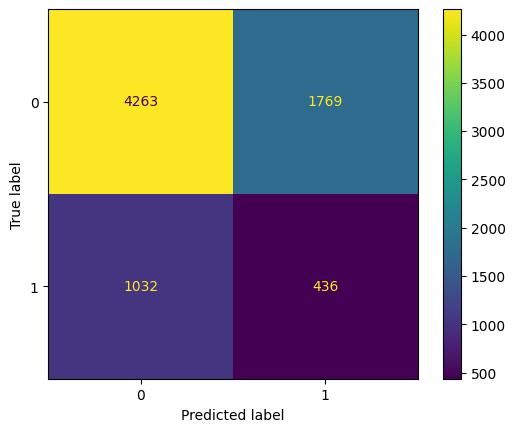

              precision    recall  f1-score   support

           0       0.81      0.71      0.75      6032
           1       0.20      0.30      0.24      1468

    accuracy                           0.63      7500
   macro avg       0.50      0.50      0.50      7500
weighted avg       0.69      0.63      0.65      7500



In [147]:
one_class_svm.fit(X_train)

y_pred = one_class_svm.predict(X_valset)

y_val = []
# Change the anomalies' values to make it consistent with the true values
for pred in y_pred:
  if pred < 0:
    y_val.append(0)
  else:
    y_val.append(1)

cm = confusion_matrix(y_valset, y_val)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

print(classification_report(y_valset, y_val))

In [148]:
y_train.value_counts()

0    13968
1     3532
Name: is_fraud, dtype: int64

### Evaluation

In [149]:
# Dataset is read from google drive
df_cc_test = pd.read_csv('fraudTest.csv')

In [150]:
df_cc_test['trans_date_trans_time'] = pd.to_datetime(df_cc_test['trans_date_trans_time'])

# Extract hour, day and month into separate columns
df_cc_test.insert(loc=1, column='hour', value=df_cc_test['trans_date_trans_time'].dt.hour)
df_cc_test.insert(loc=2, column='day', value=df_cc_test['trans_date_trans_time'].dt.day)
df_cc_test.insert(loc=3, column='month', value=df_cc_test['trans_date_trans_time'].dt.month)

In [151]:
# Applying log transformation for amt
df_cc_test['amt_log'] = np.log(df_cc_test['amt'])

df_cc_test['amt_log'].head()

0   1
1   3
2   4
3   4
4   1
Name: amt_log, dtype: float64

In [152]:
# Applying log transformation for city_pop
df_cc_test['city_pop_log'] = np.log(df_cc_test['city_pop'])

df_cc_test['city_pop_log'].head()

0   13
1    6
2   10
3   11
4    7
Name: city_pop_log, dtype: float64

In [154]:
# Convert 'dob' column to datetime format
df_cc_test['dob'] = pd.to_datetime(df_cc_test['dob'])
current_date = datetime.now()  # Get the current date

df_cc_test['age'] = (current_date - df_cc_test['dob']).dt.days // 365

df_cc_test['age'] = np.log(df_cc_test['age'])

df_cc_test['age'].head()

0   4
1   3
2   4
3   4
4   4
Name: age, dtype: float64

In [155]:
# Using Label encoder to convert all categorical variables
df_cc_test['category_enc'] = encoder.fit_transform(df_cc_test[['category']])
df_cc_test['gender_enc'] = encoder.fit_transform(df_cc_test[['gender']])
df_cc_test['state_enc'] = encoder.fit_transform(df_cc_test[['state']])

df_cc_test.head()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Unnamed: 0,hour,day,month,trans_date_trans_time,cc_num,merchant,category,amt,first,...,unix_time,merch_lat,merch_long,is_fraud,amt_log,city_pop_log,age,category_enc,gender_enc,state_enc
0,0,12,21,6,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,3,Jeff,...,1371816865,34,-81,0,1,13,4,10,1,39
1,1,12,21,6,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,30,Joanne,...,1371816873,39,-110,0,3,6,3,10,0,43
2,2,12,21,6,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41,Ashley,...,1371816893,40,-74,0,4,10,4,5,0,33
3,3,12,21,6,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60,Brian,...,1371816915,29,-81,0,4,11,4,9,1,8
4,4,12,21,6,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3,Nathan,...,1371816917,45,-86,0,1,7,4,13,1,21


In [156]:
# Create a StandardScaler object
scaler = StandardScaler()

col_to_standardize = ['lat', 'long', 'merch_lat', 'merch_long']
# Fit the scaler to your dataframe
scaler.fit(df_cc_test[col_to_standardize])

# Convert the transformed array back to a dataframe
df_cc_test[col_to_standardize] = scaler.transform(df_cc_test[col_to_standardize])


In [157]:
df_cc_test['is_fraud'].value_counts()

0    553574
1      2145
Name: is_fraud, dtype: int64

In [158]:
# Balancing the imbalanced dataset
normal_samples = df_cc_test[df_cc_test['is_fraud'] == 0].sample(n=6000, random_state=42)

anomaly_samples = df_cc_test[df_cc_test['is_fraud'] == 1].sample(n=2000, random_state=42)

test_dataset = pd.concat([normal_samples, anomaly_samples], ignore_index=True)

In [159]:
X_test = test_dataset.drop(['Unnamed: 0',	'trans_date_trans_time', 'cc_num', 'merchant',
                           'category', 'amt', 'first', 'last', 'gender', 'street', 'city',
                           'state', 'zip', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'is_fraud'], axis=1)

y_test = test_dataset['is_fraud']

In [160]:
X_test.head()

,hour,day,month,lat,long,merch_lat,merch_long,amt_log,city_pop_log,age,category_enc,gender_enc,state_enc
0,19,29,12,0,0,0,0,4,8,4,10,0,13
1,3,26,12,1,-0,1,-0,1,9,4,12,1,22
2,22,4,8,-1,1,-1,1,2,9,4,5,0,26
3,11,5,11,0,1,0,1,5,6,4,4,0,37
4,12,24,8,-1,0,-1,0,2,13,4,1,1,1


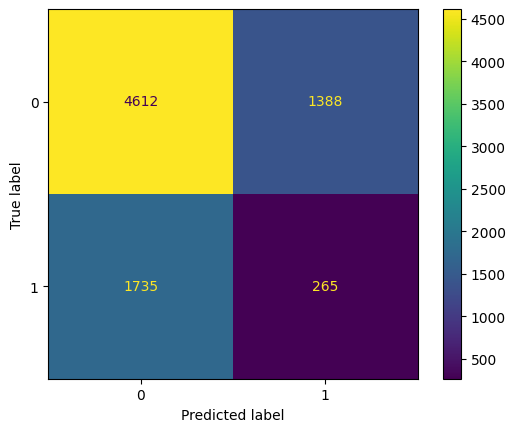

              precision    recall  f1-score   support

           0       0.73      0.77      0.75      6000
           1       0.16      0.13      0.15      2000

    accuracy                           0.61      8000
   macro avg       0.44      0.45      0.45      8000
weighted avg       0.59      0.61      0.60      8000



In [161]:
y_pred = one_class_svm.predict(X_test)

y_val = []
# Change the anomalies' values to make it consistent with the true values
for pred in y_pred:
  if pred < 0:
    y_val.append(0)
  else:
    y_val.append(1)

cm = confusion_matrix(y_test, y_val)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

print(classification_report(y_test, y_val))

### Explainability

In [ ]:
!pip install rulefit

In [ ]:
from rulefit import RuleFit

# Predict anomaly scores using One-Class SVM
anomaly_scores = one_class_svm.decision_function(X_train)

# Add the anomaly scores as a new column to the training data
X_train['anomaly_score'] = anomaly_scores

# Initialize and train the Bayesian Rule Lists model
brl_model = RuleFit(tree_size=4)
brl_model.fit(X_train, y_train)

# Generate rules from the BRL model
rules = brl_model.get_rules()

# Evaluate the BRL model on test data
rules = brl_model.get_rules()

# Evaluate the BRL model on test data
brl_predictions = brl_model.predict(X_test)

# Perform anomaly detection using BRL and One-Class SVM
combined_predictions = [1 if anomaly_score < 0 and brl_prediction == 1 else 0
                        for anomaly_score, brl_prediction in zip(anomaly_scores, brl_predictions)]
